# Практическое задание к уроку 8

### Реализовать синтезирование лиц из LFW с помощью DCGAN
### Библиотеки: [Python, Tensorflow]

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.1.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import warnings
warnings.filterwarnings('ignore')

#### Датасет LFW

In [3]:
ds, info= tfds.load('lfw', split='train',shuffle_files=True,
    as_supervised=True,with_info=True)

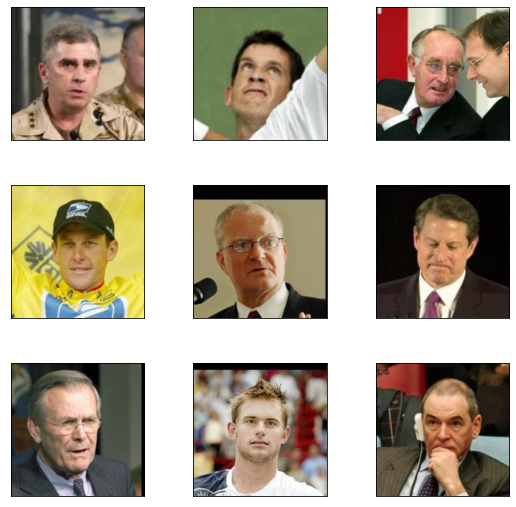

In [4]:
fig = tfds.show_examples(ds, info)

### Подготовка пайплайна данных и оптимизатора

In [5]:
def normalize_img(label,image):
    return tf.image.resize((tf.cast(image, tf.float32)-127.5) / 127.5,[128,128])

In [6]:
INPUT_DIM = 100
NUM_EPOCHS = 20
HALF_BATCH_SIZE = 16
BATCH_SIZE = HALF_BATCH_SIZE * 2
LEARNING_RATE = 0.0002


train_ds = ds.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_ds = train_ds.cache()
train_ds = train_ds.shuffle(buffer_size=info.splits['train'].num_examples)
#train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(HALF_BATCH_SIZE, drop_remainder=True)

In [7]:
generator_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
discriminator_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
sigmoid_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [8]:
train_ds

<BatchDataset shapes: (16, 128, 128, 3), types: tf.float32>

In [9]:
discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.25),    
    tf.keras.layers.Conv2D(64, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.ZeroPadding2D(padding=((0, 1), (0, 1))),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(256, kernel_size=3, strides=(1, 1), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1),
])

In [10]:
generator = tf.keras.Sequential([
    tf.keras.layers.Dense(128*8*8, activation='relu'),
    tf.keras.layers.Reshape((8, 8, 128)),
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(256, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),    
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(32, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),   
  
 
    tf.keras.layers.Conv2D(3, (2, 2), padding='same', activation='tanh'),
])


noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, 100)).astype(np.float32)
syntetic_images = generator.predict(noise)
syntetic_images.shape

(16, 128, 128, 3)

In [11]:
import os

In [12]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [13]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [15]:
def plot_digits(samples):
    fig = plt.figure(figsize=(10, 10))
    num = samples.shape[0]
    for j in range(num):
        ax = fig.add_subplot(8, 8, j+1)
        im=(samples[j, ...]*127.5+127.5)/255
        ax.imshow(im)
        plt.xticks([]), plt.yticks([])
    plt.show()
    
#plot_digits(train_x[:32, ...])

In [56]:
for epoh in range (NUM_EPOCHS):
     for step, true_images in enumerate(train_ds):

        # Train Discriminator

        noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
        syntetic_images = generator.predict(noise)
        x_combined = np.concatenate((
            true_images, 
            syntetic_images))
        y_combined = np.concatenate((
            np.ones((HALF_BATCH_SIZE, 1), np.float32), 
            np.zeros((HALF_BATCH_SIZE, 1), np.float32)))

        with tf.GradientTape() as tape:
            logits = discriminator(x_combined, training=True)
            d_loss_value = sigmoid_cross_entropy(y_combined, logits)
        grads = tape.gradient(d_loss_value, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

        # Train Generator

        noise = np.random.normal(0, 1, (BATCH_SIZE, INPUT_DIM)).astype(np.float32)
        y_mislabled = np.ones((BATCH_SIZE, 1), np.float32)

        with tf.GradientTape() as tape:
            syntetic = generator(noise, training=True)
            logits = discriminator(syntetic, training=False)
            g_loss_value = sigmoid_cross_entropy(y_mislabled, logits)
        grads = tape.gradient(g_loss_value, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(grads, generator.trainable_variables))

        # Check intermediate results

        if step % 200 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            print('[Step %2d] D Loss: %.4f; G Loss: %.4f' % (
                step, d_loss_value.numpy(), g_loss_value.numpy()))
            noise = np.random.normal(0, 1, (8, INPUT_DIM)).astype(np.float32)
            syntetic_images = generator.predict(noise)
            #plot_digits(syntetic_images)

[Step  0] D Loss: 0.3587; G Loss: 1.6647
[Step 200] D Loss: 0.5306; G Loss: 1.6984
[Step 400] D Loss: 0.3635; G Loss: 1.6746
[Step 600] D Loss: 0.3595; G Loss: 2.6246
[Step 800] D Loss: 0.5709; G Loss: 2.0591
[Step  0] D Loss: 0.3837; G Loss: 1.8553
[Step 200] D Loss: 0.6502; G Loss: 2.0440
[Step 400] D Loss: 0.2610; G Loss: 3.2689
[Step 600] D Loss: 0.5730; G Loss: 2.1591
[Step 800] D Loss: 0.5143; G Loss: 2.2551
[Step  0] D Loss: 0.4826; G Loss: 2.5338
[Step 200] D Loss: 0.5473; G Loss: 2.4333
[Step 400] D Loss: 0.6232; G Loss: 1.2325
[Step 600] D Loss: 0.6862; G Loss: 1.6105
[Step 800] D Loss: 0.2803; G Loss: 2.5480
[Step  0] D Loss: 0.5795; G Loss: 2.8856
[Step 200] D Loss: 0.4194; G Loss: 1.5680
[Step 400] D Loss: 0.4586; G Loss: 1.9304
[Step 600] D Loss: 0.4111; G Loss: 2.3922
[Step 800] D Loss: 0.2701; G Loss: 2.0408
[Step  0] D Loss: 0.6879; G Loss: 1.7304
[Step 200] D Loss: 0.5650; G Loss: 2.3176
[Step 400] D Loss: 0.4129; G Loss: 1.4113
[Step 600] D Loss: 0.4789; G Loss: 1.63

In [57]:
generator.save_weights('gen')
discriminator.save_weights('des')

In [76]:
im=(syntetic_images[0]*127.5+127.5)/255

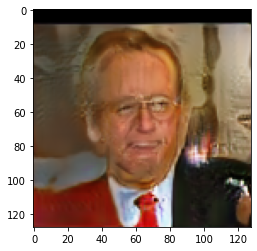

In [77]:
plt.imshow(im)

In [72]:
noise = np.random.normal(0, 1, (8, INPUT_DIM)).astype(np.float32)
syntetic_images = generator.predict(noise)

In [73]:
NUM_EPOCHS=10

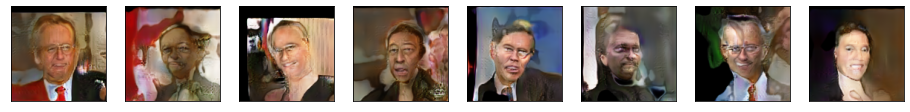

In [78]:
number=syntetic_images.shape[0]
fig=plt.figure(figsize=[16,8])

for  i in range(number):
    ax=fig.add_subplot(1,number,i+1)
    im=(syntetic_images[i]*127.5+127.5)/255
    ax.imshow(im)
    plt.xticks([]), plt.yticks([])
    
plt.show()    

In [75]:
syntetic_images.shape

(8, 128, 128, 3)